In [43]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [44]:
dados = pd.read_csv('../dados/Bicicletas.csv')
dados.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


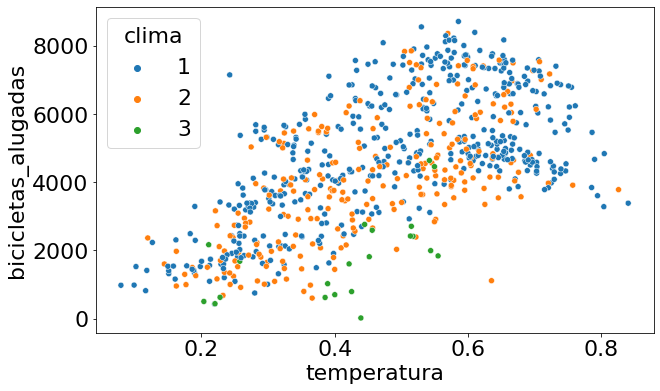

In [45]:
ax = sns.scatterplot( x = 'temperatura', y = 'bicicletas_alugadas', data = dados,
                hue = 'clima', palette = 'tab10')
ax.figure.set_size_inches(10,6)

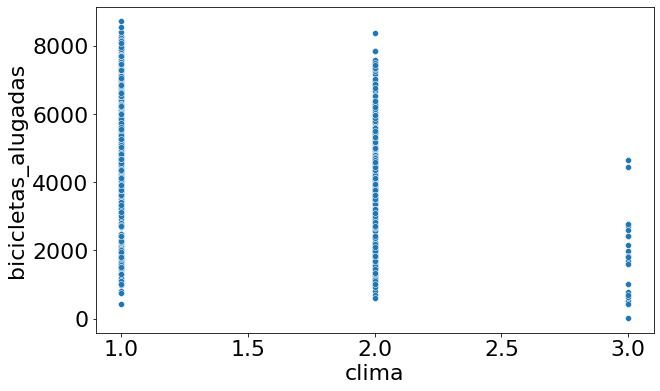

In [46]:
ax = sns.scatterplot( x = 'clima', y = 'bicicletas_alugadas', data = dados)
ax.figure.set_size_inches(10,6)

In [47]:
y = dados['bicicletas_alugadas'].values
X = dados[['clima', 'temperatura']].values

In [48]:
xmax = np.amax(X, axis = 0)
X = X/xmax


In [49]:
ymax = np.amax(y, axis = 0)
y = y/ymax


In [50]:
def sigmoid(soma):
    return 1/(1+np.exp(-soma))

In [51]:
def relu(soma):
    return np.maximum(0, soma)

In [52]:
arquitetura = [
    {'dim_entrada' : 2, 'dim_saida' : 3, 'ativacao' :"relu"},
    {'dim_entrada' : 3, 'dim_saida' : 1, 'ativacao' : "sigmoid"}

]

In [53]:
def inicia_camadas(arquitetura, seed = 99):
    # inicia os valores aleatórios
    np.random.seed(seed)

    # numero de camadas da rede neural
    numero_de_camadas = len(arquitetura)

    # inicia armazenamento de parametros
    valores_parametros = {}

    # itera nas camadas da rede
    for indice, camada in enumerate(arquitetura):

        indice_camada = indice + 1
        
        # extrai o numero de nodos nas camadas
        tamanho_camada_entrada = camada['dim_entrada']
        tamanho_camada_saida = camada['dim_saida']

        # inicia os valores na matriz de pesos P
        # e o vetor de viés ou bias b
        valores_parametros['P' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, tamanho_camada_entrada) * 0.1
        valores_parametros['b' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, 1) * 0.1

    return valores_parametros

In [54]:
def propaga_uma_camada(ativado_anterior, pesos_atuais, b_atual, ativacao = 'relu'):
    # cálculo da entrada para a função de ativação
    saida_atual = np.dot(pesos_atuais, ativado_anterior) + b_atual

    # selecção da função de ativação
    if ativacao is 'relu':
        func_ativacao = relu
    elif ativacao is 'sigmoid':
        func_ativacao = sigmoid
    else:
        raise Exception('Ainda não implementamos essa funcao')
    
    # retorna a ativação calculada Ativado_atual e a matriz intermediária Saida
    return func_ativacao(saida_atual), saida_atual

In [55]:
def propaga_total(X, valores_parametros, arquitetura):
    # memoria temporaria para a retropropagacao
    memoria = {}
    # O vetor X é a ativação para a camada 0 
    ativado_atual = X
    
    # iterações para as camadas
    for indice, camada in enumerate(arquitetura):
        # a numeração das camadas começa de 1
        indice_camada = indice + 1
        # utiliza a ativação da iteração anterior
        ativado_anterior = ativado_atual

        # extrai a função de ativação para a camada atual
        func_ativacao_atual = camada['ativacao']

        # extrai os pesos da camada atual
        pesos_atuais = valores_parametros['P' + str(indice_camada)]
        # extrai o bias para a camada atual
        b_atual = valores_parametros['b' + str(indice_camada)]
        
        # cálculo da ativação para a camada atual
        ativado_atual, saida_atual = propaga_uma_camada(ativado_anterior, pesos_atuais, b_atual, func_ativacao_atual)

        # salca os valores calculados na memória
        memoria['A' + str(indice)] = ativado_anterior
        memoria['Z' + str(indice_camada)] = saida_atual
    
    # retorna o vetor predito e um dicionário contendo os valores intermediários
    return ativado_atual, memoria


In [56]:
valores_parametros = inicia_camadas(arquitetura)


In [57]:
y_estimado, memoria = propaga_total(np.transpose(X), valores_parametros, arquitetura)

In [58]:
y_estimado[0,0] *ymax

4276.396636598154

In [59]:
y[0]*ymax

985.0000000000001

In [60]:
def valor_de_custo(Y_predito, Y):
    m = Y_predito.shape[1]
    
    custo = -1/m * (np.dot(Y, np.log(Y_predito).T) + np.dot(1-Y, np.log(1 - Y_predito).T))
    return np.squeeze(custo)

In [61]:
def atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem):
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros['P' + str(indice_camada)] -= taxa_aprendizagem * gradientes['dP' + str(indice_camada)]
        valores_parametros['b' + str(indice_camada)] -= taxa_aprendizagem * gradientes['db' + str(indice_camada)]
    return valores_parametros

In [62]:
def retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura):
    gradientes = {}

    # numero de exemplos
    # m = Y.shape[1]
    # para garantir que os dois vetores tenham a mesma dimensão
    Y = Y.reshape(Y_predito.shape)

    # inicia o algoritmo de gradiente descendente
    d_ativado_anterior = -(np.divide(Y, Y_predito) - np.divide(1-Y, 1-Y_predito))

    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        indice_camada_atual = indice_camada_anterior + 1
        # Função de ativação para a camada atual

        funcao_ativacao_atual = camada['ativacao']
        
        d_ativado_atual = d_ativado_anterior

        ativado_anterior = memoria['A' + str(indice_camada_anterior)]
        saida_atual = memoria['Z' + str(indice_camada_atual)]

        pesos_atuais = valores_parametros['P' + str(indice_camada_atual)]
        b_atual = valores_parametros['b' + str(indice_camada_atual)]

        d_ativado_anterior, d_pesos_atuais, db_atual = retropropagacao_uma_camada(d_ativado_atual, pesos_atuais, b_atual, 
                                                                                    saida_atual, ativado_anterior, funcao_ativacao_atual)
        
        gradientes['dP' + str(indice_camada_atual)] = d_pesos_atuais
        gradientes['db' + str(indice_camada_atual)] = db_atual

    return gradientes




In [63]:
def sigmoid_retro(d_ativado, saida):
    sig = sigmoid(saida)
    return d_ativado * sig * (1-sig)

def relu_retro(d_ativado, saida):
    d_saida = np.array(d_ativado, copy = True)
    d_saida[saida <= 0] = 0
    return d_saida

In [64]:
def retropropagacao_uma_camada(d_ativado_atual, pesos_atuais, b_atual, saida_atual, ativado_anterior, ativacao='relu'):
    m = ativado_anterior.shape[1]

    if ativacao is 'relu':
        func_ativacao_retro = relu_retro
    elif ativacao is 'sigmoid':
        func_ativacao_retro = sigmoid_retro
    else:
        raise Exception('Ainda não implementamos essa')

    d_saida_atual = func_ativacao_retro(d_ativado_atual, saida_atual)
    d_pesos_atuais = np.dot(d_saida_atual, ativado_anterior.T) / m
    db_atual = np.sum(d_saida_atual, axis = 1, keepdims=True) / m
    d_ativado_anterior = np.dot(pesos_atuais.T, d_saida_atual)

    return d_ativado_anterior, d_pesos_atuais, db_atual


In [65]:
def treino(X, Y, X_teste, Y_teste, arquitetura, epocas, taxa_aprendizagem):
    valores_parametros = inicia_camadas(arquitetura, 2)

    historia_custo = []
    historia_custo_teste = []

    for i in range(epocas):
        Y_predito, memoria = propaga_total(X, valores_parametros, arquitetura)

        Y_predito_teste, memoria2 = propaga_total(X_teste, valores_parametros, arquitetura)

        custo = valor_de_custo(Y_predito, Y)
        historia_custo.append(custo)
        custo_teste = valor_de_custo(Y_predito_teste, Y_teste)
        historia_custo_teste.append(custo_teste)

        gradientes = retropropagacao_total(Y_predito, Y, memoria, valores_parametros, arquitetura)

        valores_parametros = atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem)

        if i % 50:
            print(f'Iteraçao: {i : 05} - custo {custo : .5f}')

    return valores_parametros, historia_custo, historia_custo_teste

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [67]:
valores_prametros, historia_custo, historia_custo_teste = treino(np.transpose(x_train), np.transpose(y_train.reshape(y_train.shape[0],1)), np.transpose(x_test), np.transpose(y_test.reshape(y_test.shape[0],1)), arquitetura, 20000, 0.01)

0.63958
Iteraçao:  19401 - custo  0.63958
Iteraçao:  19402 - custo  0.63958
Iteraçao:  19403 - custo  0.63958
Iteraçao:  19404 - custo  0.63958
Iteraçao:  19405 - custo  0.63958
Iteraçao:  19406 - custo  0.63958
Iteraçao:  19407 - custo  0.63958
Iteraçao:  19408 - custo  0.63958
Iteraçao:  19409 - custo  0.63957
Iteraçao:  19410 - custo  0.63957
Iteraçao:  19411 - custo  0.63957
Iteraçao:  19412 - custo  0.63957
Iteraçao:  19413 - custo  0.63957
Iteraçao:  19414 - custo  0.63957
Iteraçao:  19415 - custo  0.63957
Iteraçao:  19416 - custo  0.63957
Iteraçao:  19417 - custo  0.63957
Iteraçao:  19418 - custo  0.63957
Iteraçao:  19419 - custo  0.63956
Iteraçao:  19420 - custo  0.63956
Iteraçao:  19421 - custo  0.63956
Iteraçao:  19422 - custo  0.63956
Iteraçao:  19423 - custo  0.63956
Iteraçao:  19424 - custo  0.63956
Iteraçao:  19425 - custo  0.63956
Iteraçao:  19426 - custo  0.63956
Iteraçao:  19427 - custo  0.63956
Iteraçao:  19428 - custo  0.63955
Iteraçao:  19429 - custo  0.63955
Iteraç

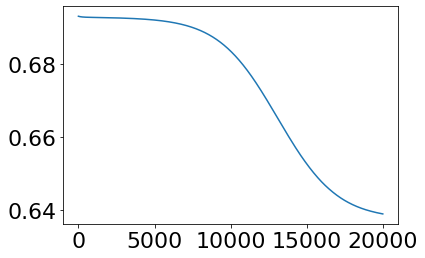

In [68]:
plt.plot(historia_custo)

In [69]:
# Previsão
Y_pred, _ = propaga_total(np.transpose(x_test), valores_parametros, arquitetura)

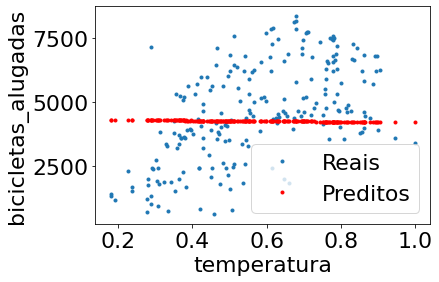

In [70]:
plt.plot(np.transpose(x_test)[1],ymax*y_test,'.')
plt.plot(np.transpose(x_test)[1],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Reais','Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('temperatura')
plt.show()

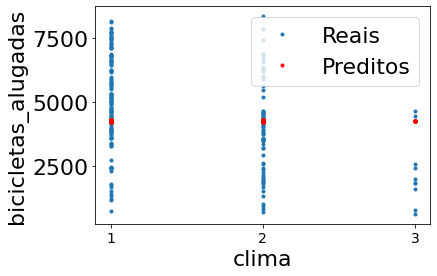

In [71]:
plt.plot(3*np.transpose(x_test)[0],ymax*y_test,'.')
plt.plot(3*np.transpose(x_test)[0],ymax*Y_pred.reshape([-1,1]),'.r')
plt.legend(['Reais','Preditos'])
plt.ylabel('bicicletas_alugadas')
plt.xlabel('clima')
plt.rcParams.update({'font.size': 22})
indice=[1,2,3]
plt.xticks(indice, fontsize=14)
plt.show()